# Correspondence Autoencoder CNN for Acoustic Word Embeddings

Herman Kamper, Stellenbosch University, 2019.

## Preliminaries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

In [2]:
sys.path.append(path.join("..", "src"))
sys.path.append(path.join("..", "embeddings"))

import batching
import data_io
import plotting
import samediff
import tflego
import training

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE

output_dir = "/tmp/data-kamperh/"

## Data

In [12]:
# Training data

# # NumPy archive (UTD)
# npz = np.load(
#     path.join("..", "features", "mfcc", "buckeye", "devpart1.utd.dd.npz")
#     )

# NumPy archive (ground truth)
npz = np.load(
    path.join("..", "features", "mfcc", "buckeye", "devpart1.samediff.dd.npz")
    )

# # NumPy archive (larger ground truth)
# npz = np.load(
#     path.join("..", "features", "mfcc", "buckeye", "devpart1.samediff2.dd.npz")
#     )

# Data and labels
i_type = 0
train_x = []
train_labels = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = utt_key.split("_")[0]
    train_labels.append(word)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 5109
E.g. item shape: (51, 39)


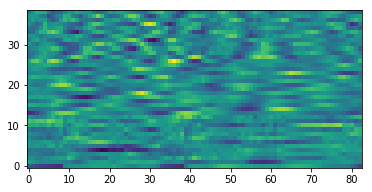

In [13]:
plt.imshow(train_x[3277].T, origin="bottom");

In [14]:
# Development data

# NumPy archive
npz = np.load(
    path.join("..", "features", "mfcc", "buckeye",
    "devpart2.samediff.dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = utt_key.split("_")[0]
    val_labels.append(word)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2732
E.g. item shape: (61, 39)


In [15]:
# Truncate and limit dimensionality
max_length = 101
d_frame = 39
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

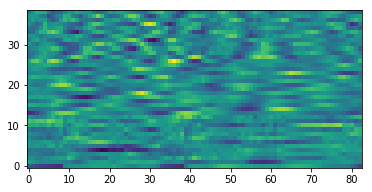

In [16]:
plt.imshow(train_x[3277].T, origin="bottom");

In [17]:
# Zero-pad and reshape
train_x, _ = data_io.pad_sequences(train_x, max_length, True)  # tune
val_x, _ = data_io.pad_sequences(val_x, max_length, True)  # tune
train_x = np.transpose(train_x, (0, 2, 1))
val_x = np.transpose(val_x, (0, 2, 1))

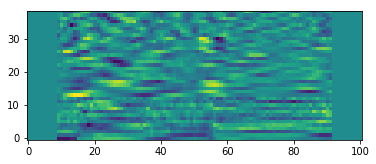

In [18]:
plt.imshow(train_x[3227], origin="bottom");

## AE-CNN

In [19]:
def get_conv2d_transpose_output_shape(input_shape, filter_shape, stride=1):
    """
    Calculate the output shape of a transposed convolution operation.
    
    See https://stackoverflow.com/questions/46885191.
    
    Parameters
    ----------
    input_shape : list
        The shape of the input to the CNN as [n_data, height, width, d_in].
    filter_shape : list
        The filter shape of as [height, width, d_out, d_in].
    """
    input_height = input_shape[1]
    input_width = input_shape[2]
    filter_height = filter_shape[0]
    filter_width = filter_shape[1]
    output_height = (input_height - 1)*stride + filter_height
    output_width = (input_width - 1)*stride + filter_width
    return [input_shape[0], output_height, output_width, filter_shape[2]]


def get_conv2d_transpose_filter_shape(input_shape, output_shape, stride=1):
    """
    Calculate the filter shape of a transposed convolution given a desired output shape.
    
    Parameters
    ----------
    input_shape : list
        The shape of the input to the CNN as [n_data, height, width, d_in].
    output_shape : list
        The shape of the output to the CNN as [n_data, height, width, d_out].

    Return
    ------
    filter_shape : list
        The filter shape of as [height, width, d_out, d_in].
    """
    input_height = input_shape[1]
    input_width = input_shape[2]
    output_height = output_shape[1]
    output_width = output_shape[2]
    filter_height = output_height - (input_height - 1)*stride
    filter_width = output_width - (input_width - 1)*stride
    return [filter_height, filter_width, output_shape[3], input_shape[3]]


In [38]:
def build_ae_cnn(x, input_shape, filter_shapes, pool_shapes,
        build_latent_func, latent_func_kwargs):
    """
    Build an autoencoding CNN.

    See `tflego.build_cnn` for more details on the parameters.

    Parameters
    ----------
    x : Tensor [n_data, n_input]
        Input to the CNN, which is reshaped to match `input_shape`.
    input_shape : list
        The shape of the input to the CNN as [n_data, height, width, d_in].
    build_latent_func : function
        The function to build the latent layer inbetween the CNN encoder and decoder.
        The function's first parameter should be the input Tensor, and it should return
        a dictionary with an element "y" giving the output.
    latent_func_kargs : dict
        Arguments to pass on to `build_latent_func`.
    """
    
    # Encoder
    network_input_shape = input_shape
    print("CNN input shape: {}".format(input_shape))
    encoder, layer_shapes = tflego.build_cnn(x, input_shape, filter_shapes, pool_shapes, padding="VALID", return_shapes=True)
    encoder = tf.contrib.layers.flatten(encoder)
    
    # Latent layer
    latent_layer = build_latent_func(encoder, **latent_func_kwargs)
    x = latent_layer["y"]
    d_latent_layer_output = x.get_shape().as_list()[-1]
    
    # Replace None with -1 in `layer_shapes`
    for i, layer in enumerate(layer_shapes):
        layer_shapes[i] = [i if i is not None else -1 for i in layer]
    decoder_pool_shapes = pool_shapes.copy()
    
    # Decoder
    i_layer = 0
    with tf.variable_scope("cnn_trans_layer_{}".format(i_layer)):
        x = tf.reshape(x, layer_shapes.pop(-1))
        decoder = tflego.build_unmaxpool2d(x, decoder_pool_shapes.pop(-1))
        print("CNN transpose layer {} shape: {}".format(i_layer, decoder.get_shape().as_list()))
    while len(decoder_pool_shapes) > 0:
        i_layer += 1
        with tf.variable_scope("cnn_trans_layer_{}".format(i_layer)):

            # Transposed convolution
            input_shape = decoder.get_shape().as_list()
            output_shape = layer_shapes.pop(-1)
            filter_shape = get_conv2d_transpose_filter_shape(input_shape, output_shape)
            decoder = tflego.build_conv2d_transpose(decoder, filter_shape)
            print("CNN transpose layer {} shape: {}".format(i_layer, decoder.get_shape().as_list()))

            # Unpool
            decoder = tflego.build_unmaxpool2d(decoder, decoder_pool_shapes.pop(-1))

    # Last decoder linear layer
    i_layer += 1
    with tf.variable_scope("cnn_trans_layer_{}".format(i_layer)):
        input_shape = decoder.get_shape().as_list()
        output_shape = network_input_shape
        filter_shape = get_conv2d_transpose_filter_shape(input_shape, output_shape)
        decoder = tflego.build_conv2d_transpose(decoder, filter_shape, activation=tf.identity)
        print("CNN transpose layer {} shape: {}".format(i_layer, decoder.get_shape().as_list()))

    return {"latent_layer": latent_layer, "decoder_output": decoder}

In [39]:
tf.reset_default_graph()

# Data
d_in = train_x.shape[1]*train_x.shape[2]
train_x_array = train_x.reshape((-1, d_in))
val_x_array = val_x.reshape((-1, d_in))

# Training parameters
learning_rate = 0.001
n_epochs = 150
n_val_interval = 5
batch_size = 600

# Model parameters
input_shape = [-1, train_x.shape[1], train_x.shape[2], 1]  # [n_data, height, width, channels]
filter_shapes = [
    [39, 8, 1, 64],
    [1, 6, 64, 256],
    [1, 5, 256, 1024]
    ]  # tune
pool_shapes = [
    [1, 2],
    [1, 2],
    [1, 17]
    ]  # tune
build_latent_func = tflego.build_autoencoder
latent_func_kwargs = {
    "enc_n_hiddens": [500],   # tune
    "n_z": 130,
    "dec_n_hiddens": [500, 1024],  # needs to be the same as channels in last conv layer
    "activation": tf.nn.relu
    }
intermediate_model_fn = path.join(output_dir, "ae_cnn.tmp.ckpt")
model_fn = path.join(output_dir, "ae_cnn.ckpt")

# Model
x = tf.placeholder(TF_DTYPE, [None, d_in])
y = tf.placeholder(TF_ITYPE, [None])

network_dict = build_ae_cnn(
    x, input_shape, filter_shapes, pool_shapes, build_latent_func, latent_func_kwargs
    )
latent = network_dict["latent_layer"]
y = network_dict["decoder_output"]


CNN input shape: [-1, 39, 101, 1]
CNN layer 0 shape: [None, 1, 47, 64]
CNN layer 1 shape: [None, 1, 21, 256]
CNN layer 2 shape: [None, 1, 1, 1024]
CNN transpose layer 0 shape: [None, 1, 17, 1024]
CNN transpose layer 1 shape: [None, 1, 21, 256]
CNN transpose layer 2 shape: [None, 1, 47, 64]
CNN transpose layer 3 shape: [None, 39, 101, 1]
